In [14]:
import pandas as pd
import datetime
import numpy as np
from datetime import timedelta
import seaborn as sns
from matplotlib.pyplot import figure
import json
import matplotlib.pyplot as plt

### Part 1 ‐ Exploratory data analysis

In [5]:
login=pd.read_json('/Users/renfeigao/Desktop/take home book/ultimate_challenge 3/logins.json')

In [9]:
ts=datetime.datetime.strptime('1970-01-01 20:12:16', "%Y-%m-%d %H:%M:%S")
login['login_time']=pd.to_datetime(login['login_time'])
login['minutes']=((((login['login_time']-ts)/np.timedelta64(1,'m'))/15).astype(int))*15
login['login_time_15']=login['minutes'].apply(lambda x: ts+ timedelta(minutes=x))

In [11]:
count_15_interval=login.login_time_15.value_counts()

(array([   0,    1,    2, ..., 9388, 9389, 9390]),
 <a list of 9391 Text xticklabel objects>)

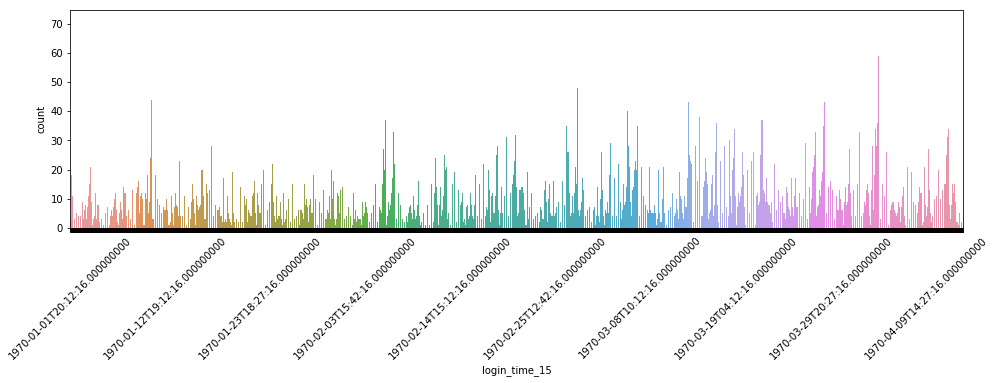

In [17]:
figure(figsize=(16,4))
ax=sns.countplot(login.login_time_15)
for ind, label in enumerate(ax.xaxis.get_ticklabels()):
    if ind % 1000 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xticks(rotation=45)

There are clearly some trends in this plot. Plot first month to check details.

(array([   0,    1,    2, ..., 2753, 2754, 2755]),
 <a list of 2756 Text xticklabel objects>)

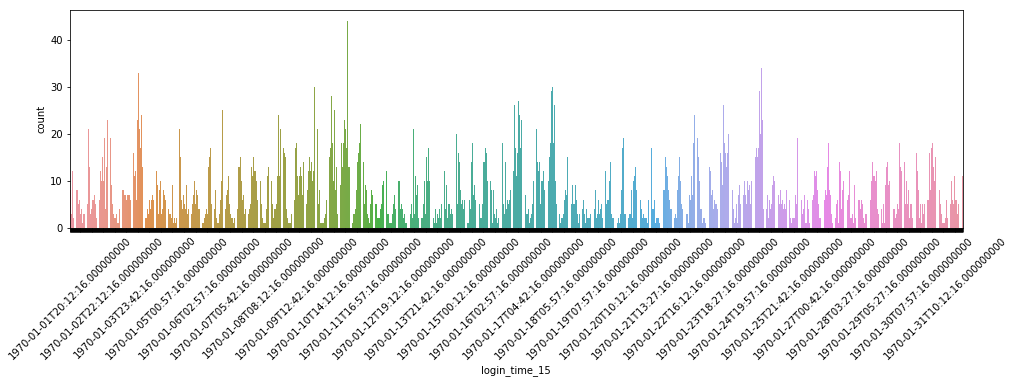

In [23]:
figure(figsize=(16,4))
ax=sns.countplot(login[(login['login_time_15'] >='1970-01-01')&(login['login_time_15']<='1970-02-01')].login_time_15)
for ind, label in enumerate(ax.xaxis.get_ticklabels()):
    if ind % 100 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xticks(rotation=45)

Obviously on weekends, there are some big peaks.

### Part 2 ‐ Experiment and metrics design

1, I will choose driver profit as a matrix. 
<br>
2, Design Experiment:
<br>
Select subsample of the drives, for these drivers, give them reimbursing all toll costs.
And for other drivers, nothing changes.
<br>
Take the experiment for about 1 month(the during is based on total driver size and sample driver size)
<br>
Collect the driver profit data.
<br>
Using Ttest to compare, 
H0: There is no significant difference between these groups.H1: there is significant difference.I will calculate p value, and using 95% confidence interval.If p value less than 0.05, then I will reject H0 and conclude that there is a significant difference. 

### Part 3 ‐ Predictive modeling

In [24]:
file = open('/Users/renfeigao/Desktop/take home book/ultimate_challenge 3/ultimate_data_challenge.json', 'r')
df = pd.DataFrame(json.load(file))
file.close()
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [39]:
#####Create retain flag
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
max_last_day=df['last_trip_date'].max()
df['retained_days']=(max_last_day-df['last_trip_date'])/np.timedelta64(1, 'D')
df['retained']=0
df.loc[df['retained_days']<=30,'retained']=1

In [33]:
####Define active
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['month']=(df['last_trip_date']-df['signup_date'])/np.timedelta64(1, 'M')
df['active']=0
df.loc[df['month']<=5,'active']=1

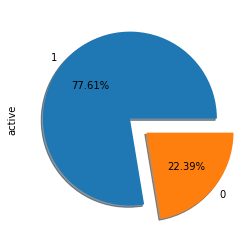

In [34]:
active=df['active'].value_counts()
active.plot.pie(explode=[0,0.25], autopct='%1.2f%%', shadow=True)

In [40]:
#### Check data missing
(len(df) - df.count())/len(df)

avg_dist                  0.00000
avg_rating_by_driver      0.00402
avg_rating_of_driver      0.16244
avg_surge                 0.00000
city                      0.00000
last_trip_date            0.00000
phone                     0.00792
signup_date               0.00000
surge_pct                 0.00000
trips_in_first_30_days    0.00000
ultimate_black_user       0.00000
weekday_pct               0.00000
retrain_days              0.00000
retained_days             0.00000
retained                  0.00000
month                     0.00000
active                    0.00000
dtype: float64

In [44]:
###Fill in missing
df.phone=df.phone.fillna('OTHER')
df.avg_rating_by_driver=df.avg_rating_by_driver.fillna(df['avg_rating_by_driver'].mean())
df.avg_rating_of_driver=df.avg_rating_of_driver.fillna(df['avg_rating_of_driver'].mean())

/Users/renfeigao/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


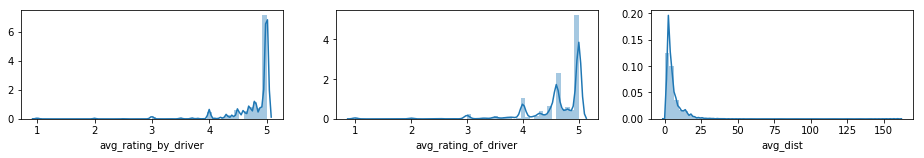

In [48]:
####Eplore some features
from matplotlib.pyplot import figure
figure(figsize=(16,2))
plt.subplot(1,3,1)
sns.distplot(df["avg_rating_by_driver"])
plt.subplot(1,3,2)
sns.distplot(df["avg_rating_of_driver"])
plt.subplot(1,3,3)
sns.distplot(df["avg_dist"])

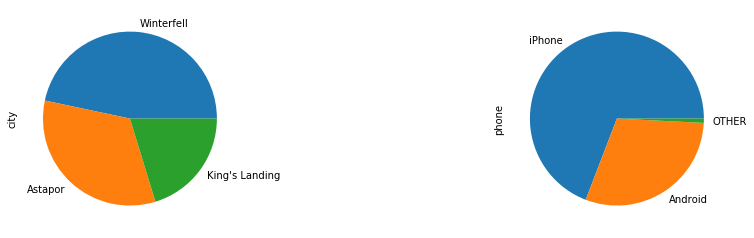

In [50]:
figure(figsize=(16,4))
def pie_plot(field,i):
    temp = df[field].value_counts()
    plt.subplot(1,2,i)
    temp.plot.pie()
pie_plot("city",1)
pie_plot("phone",2)

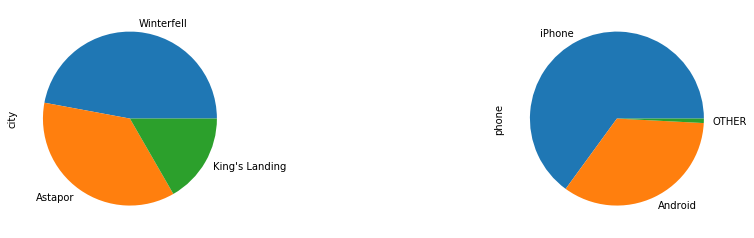

In [52]:
figure(figsize=(16,4))
def pie_plot(field,i):
    temp = df[field][df.active==1].value_counts()
    plt.subplot(1,2,i)
    temp.plot.pie()
pie_plot("city",1)
pie_plot("phone",2)

In [67]:
df_final.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'trips_in_first_30_days', 'weekday_pct', 'retrain_days',
       'retained_days', 'month', 'active', 'city_King's Landing',
       'city_Winterfell', 'phone_OTHER', 'phone_iPhone'],
      dtype='object')

In [71]:
####feature engineering, drop some feature cannot be used.
df_final = df.drop(['last_trip_date', 'signup_date', 'retained',
                   'retrain_days','month'], axis=1)
df_final=pd.get_dummies(df_final,drop_first=True)

In [72]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest=train_test_split(df_final.drop(columns=['active']),df_final['active'],
                                           stratify=df_final['active'],test_size=0.33,random_state=42)

In [73]:
####radam forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
clfForest = RandomForestClassifier(n_estimators=1000)
parameters = {"max_depth": [5,10]}#slow
gs = GridSearchCV(clfForest, param_grid=parameters, cv=5, n_jobs=4, scoring='roc_auc')
gs.fit(Xtrain,ytrain)
print("BEST", gs.best_params_, gs.best_score_, gs.grid_scores_)

BEST {'max_depth': 10} 0.9680175128205128 [mean: 0.96332, std: 0.00065, params: {'max_depth': 5}, mean: 0.96802, std: 0.00077, params: {'max_depth': 10}]


In [74]:
####xgboost
import xgboost as xgb
from xgboost import XGBClassifier
clf_xg = XGBClassifier(learning_rate =0.01, n_estimators=10000, max_depth=4, min_child_weight=1, subsample=0.8, colsample_bytree=0.8, 
                       objective= 'binary:logistic', 
            nthread=4, scale_pos_weight=2.5, seed=27, reg_lambda = 1.2)
clf_xg.fit(Xtrain, ytrain, eval_set=[(Xtrain, ytrain), (Xtest, ytest)], 
                eval_metric= 'auc', verbose= 500, early_stopping_rounds= 200)

[0]	validation_0-auc:0.968563	validation_1-auc:0.968111
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[500]	validation_0-auc:0.971068	validation_1-auc:0.968493
Stopping. Best iteration:
[707]	validation_0-auc:0.97176	validation_1-auc:0.96862



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.2, scale_pos_weight=2.5, seed=27,
       silent=True, subsample=0.8)

In [75]:
from sklearn.metrics import classification_report, roc_curve, auc,roc_auc_score
train_pred_prob=clf_xg.predict_proba(Xtrain)[:,1]
fpr,tpr,thresholds = roc_curve(ytrain,train_pred_prob)
train_auc=roc_auc_score(ytrain,train_pred_prob)
test_pred_prob=clf_xg.predict_proba(Xtest)[:,1]
fpr_test,tpr_test,thresholds_test = roc_curve(ytest,test_pred_prob)
test_auc=roc_auc_score(ytest,test_pred_prob)

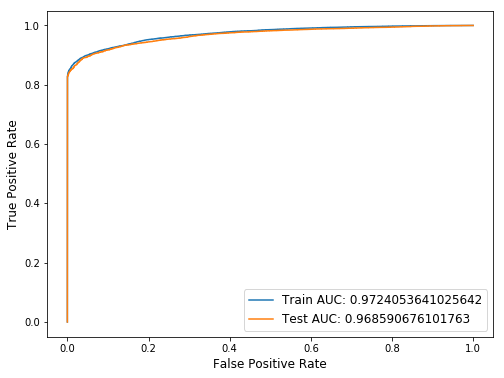

In [76]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, label='Train AUC: ' + str(train_auc))
ax.plot(fpr_test, tpr_test, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

In [77]:
feature_importances = pd.DataFrame(clf_xg.feature_importances_,
                                   index = Xtrain.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head(10)

,importance
retained_days,0.259719
avg_dist,0.157415
weekday_pct,0.104309
trips_in_first_30_days,0.094990
avg_rating_by_driver,0.080461
surge_pct,0.065631
avg_rating_of_driver,0.053006
avg_surge,0.049299
city_King's Landing,0.042084
phone_iPhone,0.034269


From this, we can see, the retained days is most important. Then avereage distance is second important. If it is too far, people don't want to drive very actively.